In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q fastai==2.1.2

     |████████████████████████████████| 194kB 8.6MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 


In [3]:
!pip install fastcore==1.3.1

     |████████████████████████████████| 51kB 4.4MB/s 
  Found existing installation: fastcore 1.3.13
    Uninstalling fastcore-1.3.13:
      Successfully uninstalled fastcore-1.3.13


In [4]:
from fastai import *
import pandas as pd
from fastai.tabular.all import *

In [5]:
from fastcore import __version__
print(__version__)

1.3.1


In [6]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 194kB 7.8MB/s 


In [7]:
from fastai.tabular import *

In [8]:
train = pd.read_csv("/content/drive/My Drive/pisos_uniq.csv")
test = pd.read_csv("/content/drive/My Drive/pisos_unique_test.csv")

In [9]:
test.fillna(value = test.mean(), inplace = True)

In [10]:
train.fillna(value = train.mean(), inplace = True)

In [11]:
train.drop("ID", axis = 1, inplace = True)
test.drop("ID", axis = 1, inplace = True)

In [12]:
train.head()

,Price,Sqft_m2,RatioEurM,Rooms,Toilets,Area,Elevator,Parking,Heating,CoolAir,Construction,Balcony
0,590000,70,8429,3.0,2.0,Esquerra Alta de l´Eixample,Yes,No,Yes,No,New,Yes
1,320000,105,3048,4.0,1.0,Guinardó,Yes,No,Yes,Yes,Not New,No
2,269000,76,3539,3.0,2.0,Guinardó,Yes,No,Yes,No,Not New,No
3,269000,76,3539,3.0,2.0,Guinardó,Yes,No,Yes,No,Not New,No
4,239000,79,3025,2.0,1.0,Congrés - Indians,Yes,No,Yes,Yes,Not New,No


In [13]:
dep_var = 'Price'

In [14]:
cat_names = [ 'Area','Elevator','Parking', 'Heating', 'CoolAir', 'Construction', 'Balcony' ]
#cat_names = []

In [15]:
cont_names = [ 'Sqft_m2', 'Rooms', 'Toilets']

In [16]:
print("Categorical columns are : ", cat_names)


Categorical columns are :  ['Area', 'Elevator', 'Parking', 'Heating', 'CoolAir', 'Construction', 'Balcony']


In [17]:
print('Continuous numerical columns are :', cont_names)


Continuous numerical columns are : ['Sqft_m2', 'Rooms', 'Toilets']


In [18]:
procs = [Categorify,FillMissing, Normalize]

In [19]:
#data = TabularDataLoaders.from_df(train, 
#                            cat_names=cat_names, 
#                            cont_names=cont_names, 
#                            valid_idx=list( np.random.permutation(len(train))[:int(len(train)*.1)]),
#                            procs=procs)

In [20]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train))

In [21]:
 to = TabularPandas(train, 
                   procs=procs,
                   y_names=dep_var,
                   cat_names = cat_names,
                   cont_names = cont_names,
                   splits=splits)

In [22]:
to_test = TabularPandas(test, procs, cat_names, cont_names, y_names="Price")

In [23]:
test_dl = TabDataLoader(to_test, bs=128, shuffle=False, drop_last=False)

In [24]:
to.xs.iloc[:2]

,Area,Elevator,Parking,Heating,CoolAir,Construction,Balcony,Sqft_m2,Rooms,Toilets
2736,65,2,1,1,2,2,2,-1.34607,-0.73605,-0.680175
731,52,1,1,2,1,2,1,1.11687,-0.73605,1.216899


In [25]:
dls = to.dataloaders(bs=64)

In [26]:
test_dl = dls.test_dl(test, with_labels=True)

In [27]:
dls.show_batch()

,Area,Elevator,Parking,Heating,CoolAir,Construction,Balcony,Sqft_m2,Rooms,Toilets,Price
0,La Salut,Yes,Yes,Yes,No,New,Yes,114.000000,4.0,2.0,650000.0
1,Esquerra Alta de l´Eixample,Yes,No,Yes,Yes,Not New,No,158.999997,4.0,2.0,800000.0
2,Esquerra Baixa de l´Eixample,Yes,No,Yes,No,Not New,Yes,93.000000,3.0,2.0,595000.0
3,Poblenou,Yes,No,No,No,Not New,No,86.000000,2.0,2.0,469000.0
4,Carmel,Yes,Yes,No,No,New,Yes,61.999999,3.0,1.0,258000.0
5,Besòs - Maresme,Yes,No,No,No,Not New,Yes,77.000000,3.0,2.0,163000.0
6,Raval,Yes,No,Yes,No,Not New,No,74.000000,2.0,1.0,299000.0
7,Llefià,Yes,No,Yes,No,Not New,No,84.000000,3.0,1.0,158000.0
8,Esquerra Baixa de l´Eixample,Yes,No,Yes,No,Not New,No,85.000000,3.0,2.0,380000.0
9,Santa Rosa,No,No,No,Yes,Not New,No,65.000000,3.0,1.0,149500.0


In [28]:
learn = tabular_learner(dls,metrics=accuracy)

In [29]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(78, 18)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(39, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=39, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

SuggestedLRs(lr_min=1.0, lr_steep=0.0001258925476577133)

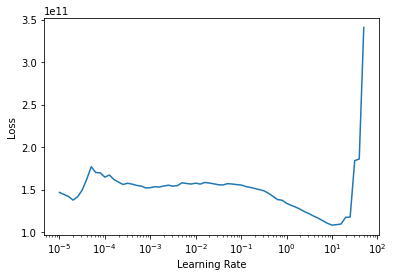

In [30]:
#learn.lr_find()
learn.lr_find(start_lr = 1e-05,end_lr =1e+05)

In [31]:
learn.fit_one_cycle(100,lr_max=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,148860846080.000000,150096510976.000000,0.000000,00:00
1,150382166016.000000,150078111744.000000,0.000000,00:00
2,149437661184.000000,150027567104.000000,0.000000,00:00
3,148908392448.000000,149879029760.000000,0.000000,00:00
4,150317613056.000000,149536899072.000000,0.000000,00:00
5,150103310336.000000,148668530688.000000,0.000000,00:00
6,149125955584.000000,146784075776.000000,0.000000,00:00
7,144439443456.000000,142857076736.000000,0.000000,00:00
8,139549048832.000000,135353712640.000000,0.000000,00:00
9,133365710848.000000,122218913792.000000,0.000000,00:00


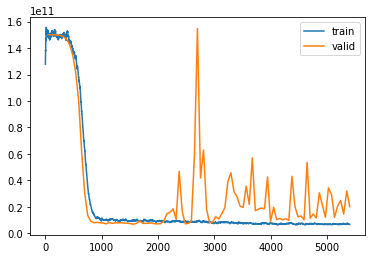

In [32]:
learn.recorder.plot_loss()

In [33]:
learn.show_results()

,Area,Elevator,Parking,Heating,CoolAir,Construction,Balcony,Sqft_m2,Rooms,Toilets,Price,Price_pred
0,21.0,2.0,1.0,2.0,1.0,2.0,2.0,0.166878,-0.736050,1.216899,470000.0,544988.000000
1,47.0,1.0,1.0,1.0,1.0,2.0,1.0,-0.853482,0.324045,-0.680175,167000.0,151935.359375
2,74.0,1.0,1.0,2.0,1.0,2.0,1.0,-1.134961,-0.736050,-0.680175,125000.0,140740.093750
3,59.0,2.0,1.0,1.0,1.0,2.0,1.0,-0.325709,0.324045,-0.680175,170000.0,419504.531250
4,46.0,2.0,2.0,1.0,1.0,1.0,1.0,-0.677558,-0.736050,-0.680175,296000.0,401614.937500
5,55.0,2.0,2.0,2.0,1.0,1.0,2.0,0.518727,0.324045,1.216899,530000.0,500819.031250
6,75.0,1.0,2.0,1.0,1.0,1.0,1.0,-0.325709,-0.736050,1.216899,390000.0,383577.343750
7,32.0,1.0,1.0,1.0,2.0,2.0,1.0,-0.360894,-0.736050,-0.680175,156000.0,119739.156250
8,68.0,2.0,1.0,1.0,1.0,1.0,1.0,-1.134961,-1.796145,-0.680175,335000.0,344278.531250


In [34]:
dls.show_batch()

,Area,Elevator,Parking,Heating,CoolAir,Construction,Balcony,Sqft_m2,Rooms,Toilets,Price
0,Fort Pienc,Yes,No,Yes,Yes,Not New,Yes,130.000000,4.0,2.0,395000.0
1,Fort Pienc,No,Yes,Yes,No,Not New,Yes,105.000001,2.0,1.0,405000.0
2,La Bordeta,No,No,No,Yes,Not New,No,73.000000,3.0,1.0,222500.0
3,Congrés - Indians,Yes,No,Yes,No,New,Yes,73.000000,2.0,1.0,350000.0
4,Les Corts,Yes,No,Yes,No,New,No,77.000000,2.0,1.0,320000.0
5,Esquerra Baixa de l´Eixample,Yes,No,Yes,Yes,Not New,No,157.999997,4.0,2.0,550000.0
6,La Florida,No,No,No,Yes,Not New,No,65.000000,2.0,1.0,115000.0
7,Badal,Yes,No,No,Yes,Not New,No,60.000001,2.0,1.0,239000.0
8,Dreta de l´Eixample,Yes,No,No,No,New,Yes,76.000000,2.0,1.0,505000.0
9,St Pere - Sta Caterina - El Born,Yes,No,Yes,No,Not New,No,41.000000,1.0,1.0,210000.0


In [35]:
learn.validate(dl=test_dl)

(#2) [3957689856.0,0.0]

In [36]:
preds = learn.get_preds(dl=test_dl)